In [40]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely.geometry
from shapely.geometry import Point, Polygon, LineString
import urllib
from descartes import PolygonPatch
import zipfile
import os
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [41]:
nyc = gpd.read_file('Borough Boundaries/geo_export_663c4f84-8c5e-4d7e-8346-d3dd3ec4b74f.shp')

<AxesSubplot:>

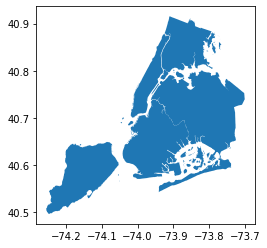

In [42]:
nyc.plot()

In [43]:
nyc = nyc.loc[(nyc.boro_code!=5)].copy()

In [213]:
nyc

,boro_code,boro_name,shape_area,shape_leng,geometry
1,2.0,Bronx,1.187231e+09,464720.015850,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,4.0,Queens,3.042318e+09,903938.441308,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
4,1.0,Manhattan,6.366055e+08,359935.015632,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."


<AxesSubplot:>

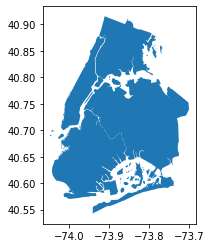

In [165]:
nyc.plot()

## Census Tracts

In [44]:
tracts = gpd.read_file('Tracts/nyu_2451_34161.shp')

In [236]:
tracts.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [45]:
tracts = tracts.to_crs('epsg:4326')

In [46]:
tracts['TractID'] = pd.to_numeric(tracts['CTLABEL'],errors='coerce')
tracts['TractID'] = 100 * tracts['TractID']
tracts['TractID'] = tracts['TractID'].astype(int)
tracts.head(2)

,CTLABEL,BOROCODE,BORONAME,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry,TractID
0,43,4,Queens,004300,4004300,E,QN68,Qnsbridge-Ravenswd-LngIslCityN,4101,6401.411786,1.838665e+06,6401.411871,"POLYGON ((-73.93541 40.76350, -73.93398 40.762...",4300
1,44.01,4,Queens,004401,4004401,E,QN56,Ozone Park,4113,7561.021748,2.776681e+06,7561.021754,"POLYGON ((-73.85748 40.67817, -73.85687 40.676...",4401


In [41]:
population = pd.read_csv('CensusData/DECENNIALPL2010.csv', skiprows=1)

In [42]:
population.head()

,id,Geographic Area Name,Total,Total!!Population of one race,Total!!Population of one race!!White alone,Total!!Population of one race!!Black or African American alone,Total!!Population of one race!!American Indian and Alaska Native alone,Total!!Population of one race!!Asian alone,Total!!Population of one race!!Native Hawaiian and Other Pacific Islander alone,Total!!Population of one race!!Some Other Race alone,...,Total!!Two or More Races!!Population of four races!!American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of five races,Total!!Two or More Races!!Population of five races!!White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander,Total!!Two or More Races!!Population of five races!!White; Black or African American; American Indian and Alaska Native; Asian; Some Other Race,Total!!Two or More Races!!Population of five races!!White; Black or African American; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of five races!!White; Black or African American; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of five races!!White; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of five races!!Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of six races,Total!!Two or More Races!!Population of six races!!White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race
0,1400000US36001000100,"Census Tract 1, Albany County, New York",2139,2050,506,1396,9,55,0,84,...,0,0,0,0,0,0,0,0,0,0
1,1400000US36001000200,"Census Tract 2, Albany County, New York",6046,5819,840,4647,12,57,0,263,...,0,0,0,0,0,0,0,0,0,0
2,1400000US36001000300,"Census Tract 3, Albany County, New York",5888,5629,2941,2199,19,213,1,256,...,0,0,0,0,0,0,0,0,0,0
3,1400000US36001000401,"Census Tract 4.01, Albany County, New York",2227,2200,1921,205,2,56,0,16,...,0,0,0,0,0,0,0,0,0,0
4,1400000US36001000403,"Census Tract 4.03, Albany County, New York",4415,4314,3386,427,5,443,1,52,...,0,0,0,0,0,0,0,0,0,0


In [44]:
population['TractID'] = population['id'].str[-6:] # add county code to this too... need another differentiator
population['TractID'] = pd.to_numeric(population['TractID'],errors='coerce')
population['JoinID'] = population['id'].str[-11:]
population['CountyCode']=population['id'].str[-9:-6]
popNY = population.loc[(population['CountyCode'].isin(['005','085','047','061','081']))]
popNY.head()

,id,Geographic Area Name,Total,Total!!Population of one race,Total!!Population of one race!!White alone,Total!!Population of one race!!Black or African American alone,Total!!Population of one race!!American Indian and Alaska Native alone,Total!!Population of one race!!Asian alone,Total!!Population of one race!!Native Hawaiian and Other Pacific Islander alone,Total!!Population of one race!!Some Other Race alone,...,Total!!Two or More Races!!Population of five races!!White; Black or African American; American Indian and Alaska Native; Asian; Some Other Race,Total!!Two or More Races!!Population of five races!!White; Black or African American; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of five races!!White; Black or African American; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of five races!!White; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of five races!!Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total!!Two or More Races!!Population of six races,Total!!Two or More Races!!Population of six races!!White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,TractID,JoinID,CountyCode
88,1400000US36005000100,"Census Tract 1, Bronx County, New York",11091,11085,1724,6515,117,180,28,2521,...,0,0,0,0,0,0,0,100.0,36005000100,005
89,1400000US36005000200,"Census Tract 2, Bronx County, New York",4334,4084,1332,1264,52,140,15,1281,...,0,0,0,0,0,0,0,200.0,36005000200,005
90,1400000US36005000400,"Census Tract 4, Bronx County, New York",5503,5145,1497,1735,48,124,6,1735,...,0,0,0,0,0,0,0,400.0,36005000400,005
91,1400000US36005001600,"Census Tract 16, Bronx County, New York",5643,5328,1556,2293,54,63,0,1362,...,0,0,0,0,0,0,0,1600.0,36005001600,005
92,1400000US36005001900,"Census Tract 19, Bronx County, New York",1917,1839,591,641,22,25,1,559,...,0,0,0,0,0,0,0,1900.0,36005001900,005


In [46]:
popNY = popNY[['id', 'Geographic Area Name', 'TractID', 'JoinID', 'CountyCode', 'Total']].copy()
popNY.columns = ['GeoID', 'Geographic Area Name', 'TractID', 'JoinID', 'CountyCode', 'Population']

In [74]:
counties = {
    '005':'2',
    '085':'5',
    '047':'3',
    '061':'1',
    '081':'4'
}
popNY['BOROCODE'] = popNY['CountyCode'].map(counties)

In [70]:
Income['TractID'] = Income['GeoID'].str[-6:] # add county code to this too... need another differentiator
Income['TractID'] = pd.to_numeric(Income['TractID'],errors='coerce')

NameError: name 'Income' is not defined

In [291]:
Income['JoinID'] = Income['GeoID'].str[-11:]
Income['CountyCode']=Income['GeoID'].str[-9:-6]

In [292]:
IncomeNY = Income.loc[(Income['CountyCode'].isin(['005','085','047','061','081']))]
IncomeNY.head()

,GeoID,Desc,Income,TractID,JoinID,CountyCode
86,1400000US36005000200,"Census Tract 2, Bronx County, New York",72034.0,200,36005000200,005
87,1400000US36005000400,"Census Tract 4, Bronx County, New York",74836.0,400,36005000400,005
88,1400000US36005001600,"Census Tract 16, Bronx County, New York",32312.0,1600,36005001600,005
89,1400000US36005001900,"Census Tract 19, Bronx County, New York",37936.0,1900,36005001900,005
90,1400000US36005002000,"Census Tract 20, Bronx County, New York",18086.0,2000,36005002000,005


In [293]:
IncomeNY.shape

(2100, 6)

In [294]:
counties = {
    '005':'The Bronx',
    '085':'Staten Island',
    '047':'Brooklyn',
    '061':'Manhattan',
    '081':'Queens'
}
IncomeNY['BORONAME'] = IncomeNY['CountyCode'].map(counties)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [295]:
tracts['BORONAME'].unique()

array(['Queens', 'The Bronx', 'Manhattan', 'Brooklyn', 'Staten Island'],
      dtype=object)

In [296]:
merged = pd.merge(IncomeNY, tracts, on=['TractID','BORONAME'], how ='inner')
merged.head()

,GeoID,Desc,Income,TractID,JoinID,CountyCode,BORONAME,CTLABEL,BOROCODE,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1400000US36005000200,"Census Tract 2, Bronx County, New York",72034.0,200,36005000200,005,The Bronx,2,2,000200,2000200,I,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,11987.703201,4.774385e+06,11987.703239,"POLYGON ((-73.85562 40.81061, -73.85546 40.809..."
1,1400000US36005000400,"Census Tract 4, Bronx County, New York",74836.0,400,36005000400,005,The Bronx,4,2,000400,2000400,E,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,21428.307398,8.402563e+06,21428.307306,"MULTIPOLYGON (((-73.85546 40.80997, -73.85562 ..."
2,1400000US36005001600,"Census Tract 16, Bronx County, New York",32312.0,1600,36005001600,005,The Bronx,16,2,001600,2001600,E,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,9671.305917,5.221333e+06,9671.305797,"POLYGON ((-73.85472 40.81594, -73.85562 40.815..."
3,1400000US36005002000,"Census Tract 20, Bronx County, New York",18086.0,2000,36005002000,005,The Bronx,20,2,002000,2002000,E,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,8332.248019,4.270674e+06,8332.248120,"POLYGON ((-73.86246 40.81925, -73.86208 40.817..."
4,1400000US36005002300,"Census Tract 23, Bronx County, New York",14479.0,2300,36005002300,005,The Bronx,23,2,002300,2002300,E,BX39,Mott Haven - Port Morris,3710,4717.360109,1.126491e+06,4717.360076,"POLYGON ((-73.92476 40.80739, -73.92652 40.808..."


In [297]:
test = merged.groupby(by = 'JoinID').count()
test.loc[(test.GeoID > 1)]

,GeoID,Desc,Income,TractID,CountyCode,BORONAME,CTLABEL,BOROCODE,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
JoinID,,,,,,,,,,,,,,,,,,
36085027702,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
36085029102,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [298]:
#merged.loc[(merged.JoinID =='36085027702')]
#36085027702
#36085029102
badIDs = ['36085029102', '36085027702']
keepRows = ((merged.JoinID.isin(badIDs)==False) | (merged.CT2000.str[-3:,1] == merged.JoinID.str[-3:,1]))

merged = merged.loc[keepRows]

merged['JoinID'] = pd.to_numeric(merged['JoinID'],errors='coerce')

In [299]:
test = merged.groupby(by = 'JoinID').count()
test.loc[(test.GeoID > 1)]

,GeoID,Desc,Income,TractID,CountyCode,BORONAME,CTLABEL,BOROCODE,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
JoinID,,,,,,,,,,,,,,,,,,


In [300]:
population = pd.read_csv('CombinedDemographicsTable.csv')

In [301]:
merged.columns

Index(['GeoID', 'Desc', 'Income', 'TractID', 'JoinID', 'CountyCode',
       'BORONAME', 'CTLABEL', 'BOROCODE', 'CT2000', 'BOROCT2000', 'CDELIGIBIL',
       'PJAREACODE', 'PJAREANAME', 'PUMA', 'SHAPE_LENG', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')

In [302]:
population.head()

,id,Geographic Area Name,Population,Num Under Poverty,Num Over Poverty,Pct_Und_Pov,Pct_Ovr_Pov,idChar,Median Income,Field3,Field4
0,36001000100,"Census Tract 1, Albany County, New York",453,159,294,35.0993377483444,64.9006622516556,36001000100,25179.0,13.717848791893999,22.915042868277474
1,36001000200,"Census Tract 2, Albany County, New York",935,366,569,39.144385026738,60.855614973262,36001000200,26337.0,22.472324723247233,15.018450184501845
2,36001000300,"Census Tract 3, Albany County, New York",862,213,649,24.7099767981439,75.2900232018561,36001000300,32244.0,28.939597315436242,12.751677852348994
3,36001000401,"Census Tract 4.01, Albany County, New York",417,9,408,2.15827338129496,97.841726618705,36001000401,72168.0,47.579529737206087,4.2415859843245736
4,36001000403,"Census Tract 4.03, Albany County, New York",909,10,899,1.1001100110011,98.8998899889989,36001000403,52857.0,59.130434782608695,9.6894409937888195


In [303]:
population = population.drop_duplicates()
population.shape

(4822, 11)

In [304]:
population.dtypes
merged.dtypes

GeoID           object
Desc            object
Income         float64
TractID          int64
JoinID           int64
CountyCode      object
BORONAME        object
CTLABEL         object
BOROCODE        object
CT2000          object
BOROCT2000      object
CDELIGIBIL      object
PJAREACODE      object
PJAREANAME      object
PUMA            object
SHAPE_LENG     float64
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [305]:
merged.get('JoinID', default='Error!')


0       36005000200
1       36005000400
2       36005001600
3       36005002000
4       36005002300
           ...     
1868    36005028400
1869    36061002100
1870    36047001800
1871    36061024000
1872    36061003300
Name: JoinID, Length: 1869, dtype: int64

In [306]:
merged2 = pd.merge(merged, population, on=['JoinID','id'], how ='left')
merged2.head()

KeyError: 'JoinID'

In [307]:
tractsInfo = GeoDataFrame(merged, crs="EPSG:4326", geometry=merged.geometry)
tractsInfo

,GeoID,Desc,Income,TractID,JoinID,CountyCode,BORONAME,CTLABEL,BOROCODE,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1400000US36005000200,"Census Tract 2, Bronx County, New York",72034.0,200,36005000200,005,The Bronx,2,2,000200,2000200,I,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,11987.703201,4.774385e+06,11987.703239,"POLYGON ((-73.85562 40.81061, -73.85546 40.809..."
1,1400000US36005000400,"Census Tract 4, Bronx County, New York",74836.0,400,36005000400,005,The Bronx,4,2,000400,2000400,E,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,21428.307398,8.402563e+06,21428.307306,"MULTIPOLYGON (((-73.85546 40.80997, -73.85562 ..."
2,1400000US36005001600,"Census Tract 16, Bronx County, New York",32312.0,1600,36005001600,005,The Bronx,16,2,001600,2001600,E,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,9671.305917,5.221333e+06,9671.305797,"POLYGON ((-73.85472 40.81594, -73.85562 40.815..."
3,1400000US36005002000,"Census Tract 20, Bronx County, New York",18086.0,2000,36005002000,005,The Bronx,20,2,002000,2002000,E,BX09,Soundview-CastleHl-ClasonPt-HardngPk,3709,8332.248019,4.270674e+06,8332.248120,"POLYGON ((-73.86246 40.81925, -73.86208 40.817..."
4,1400000US36005002300,"Census Tract 23, Bronx County, New York",14479.0,2300,36005002300,005,The Bronx,23,2,002300,2002300,E,BX39,Mott Haven - Port Morris,3710,4717.360109,1.126491e+06,4717.360076,"POLYGON ((-73.92476 40.80739, -73.92652 40.808..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,1400000US36005028400,"Census Tract 284, Bronx County, New York",NaN,28400,36005028400,005,The Bronx,284,2,028400,2028400,I,BX37,VanNest-MorrisPk-WstcstrSq,3704,25227.093715,1.094026e+07,25227.093878,"POLYGON ((-73.82873 40.86041, -73.83055 40.858..."
1869,1400000US36061002100,"Census Tract 21, New York County, New York",NaN,2100,36061002100,061,Manhattan,21,1,002100,1002100,I,MN24,SoHo-Tribeca-CivcCentr-LittleItaly,3810,6810.496164,2.613284e+06,6810.496235,"POLYGON ((-74.00754 40.71543, -74.00589 40.714..."
1870,1400000US36047001800,"Census Tract 18, Kings County, New York",NaN,1800,36047001800,047,Brooklyn,18,3,001800,3001800,E,BK32,Sunset Park West,4012,54824.436799,2.619511e+07,54824.437174,"POLYGON ((-73.99585 40.66797, -73.99507 40.667..."
1871,1400000US36061024000,"Census Tract 240, New York County, New York",NaN,24000,36061024000,061,Manhattan,240,1,024000,1024000,I,MN99,park_cemetery_etc_MN,3804,23873.695059,2.355233e+07,23873.694990,"POLYGON ((-73.92570 40.80181, -73.92549 40.801..."


# Citi Bike

In [71]:
def unzipFiles(path):
    files=os.listdir(path)
    for file in files:
        if file.endswith('.zip'):
            filePath=path+'/'+file
            zip_file = zipfile.ZipFile(filePath)
            for names in zip_file.namelist():
                zip_file.extract(names,path)
            zip_file.close() 

In [72]:
path = '/Users/nicoleallegretti/Desktop/NYU/Courses/03_Summer21/Capstone/Data/CitiBike'
unzipFiles(path)

In [47]:
folder = 'CitiBike/'
files = [folder+'201901-citibike-tripdata.csv',
        folder+'201902-citibike-tripdata.csv',
        folder+'201903-citibike-tripdata.csv',
        folder+'201904-citibike-tripdata.csv',
        folder+'201905-citibike-tripdata.csv',
        folder+'201906-citibike-tripdata.csv',
        folder+'201907-citibike-tripdata.csv',
        folder+'201908-citibike-tripdata.csv',
        folder+'201909-citibike-tripdata.csv',
        folder+'201910-citibike-tripdata.csv',
        folder+'201911-citibike-tripdata.csv',
        folder+'201912-citibike-tripdata.csv']

In [48]:
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

In [49]:
cb = pd.concat(dfs)

In [50]:
cb.loc[(cb.tripduration < (30))|(cb.tripduration>(3600*8))]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
741,34407,2019-01-01 03:14:57.4460,2019-01-01 12:48:24.5500,3158.0,W 63 St & Broadway,40.771639,-73.982614,3165.0,Central Park West & W 72 St,40.775794,-73.976206,33158,Customer,1992,1
3877,190180,2019-01-01 11:28:38.6610,2019-01-03 16:18:19.3460,409.0,DeKalb Ave & Skillman St,40.690649,-73.956431,353.0,S Portland Ave & Hanson Pl,40.685396,-73.974315,25468,Customer,1969,0
5228,64387,2019-01-01 12:16:00.8660,2019-01-02 06:09:07.9650,539.0,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3295.0,Central Park W & W 96 St,40.791270,-73.964839,34323,Subscriber,1986,2
5824,108271,2019-01-01 12:34:17.2150,2019-01-02 18:38:49.0930,3641.0,Broadway & W 25 St,40.742869,-73.989186,387.0,Centre St & Chambers St,40.712733,-74.004607,26414,Customer,1969,0
6691,76276,2019-01-01 12:58:44.7080,2019-01-02 10:10:01.4380,3478.0,2 Ave & 36 St - Citi Bike HQ at Industry City,40.657089,-74.008702,3478.0,2 Ave & 36 St - Citi Bike HQ at Industry City,40.657089,-74.008702,16104,Customer,1975,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954919,47194,2019-12-31 23:15:49.7730,2020-01-01 12:22:24.0390,3136.0,5 Ave & E 63 St,40.766368,-73.971518,3898.0,E 63 St & 3 Ave,40.763954,-73.964600,39700,Customer,1969,0
954923,62451,2019-12-31 23:16:07.6860,2020-01-01 16:36:59.4580,3136.0,5 Ave & E 63 St,40.766368,-73.971518,3898.0,E 63 St & 3 Ave,40.763954,-73.964600,19213,Customer,1969,0
954943,60683,2019-12-31 23:19:46.7680,2020-01-01 16:11:10.2440,3142.0,1 Ave & E 62 St,40.761227,-73.960940,2022.0,E 60 St & York Ave,40.759107,-73.959223,40616,Customer,1996,1
955042,30713,2019-12-31 23:30:30.7520,2020-01-01 08:02:24.1890,479.0,9 Ave & W 45 St,40.760193,-73.991255,447.0,8 Ave & W 52 St,40.763707,-73.985162,41369,Customer,1969,0


In [149]:

cb.loc[(cb['start station id']==cb['end station id'])]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
24,643,2019-01-01 00:24:10.9070,2019-01-01 00:34:54.2950,484.0,W 44 St & 5 Ave,40.755003,-73.980144,484.0,W 44 St & 5 Ave,40.755003,-73.980144,34089,Subscriber,1975,1
93,468,2019-01-01 00:49:05.1410,2019-01-01 00:56:53.2090,195.0,Liberty St & Broadway,40.709056,-74.010434,195.0,Liberty St & Broadway,40.709056,-74.010434,20120,Subscriber,1980,1
103,714,2019-01-01 00:53:25.5970,2019-01-01 01:05:19.7410,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,15693,Subscriber,1987,2
131,64,2019-01-01 00:59:30.8450,2019-01-01 01:00:35.2920,402.0,Broadway & E 22 St,40.740343,-73.989551,402.0,Broadway & E 22 St,40.740343,-73.989551,34775,Customer,1983,1
154,2904,2019-01-01 01:03:15.0920,2019-01-01 01:51:39.3010,487.0,E 20 St & FDR Drive,40.733143,-73.975739,487.0,E 20 St & FDR Drive,40.733143,-73.975739,17370,Subscriber,1963,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955119,3833,2019-12-31 23:39:28.8520,2020-01-01 00:43:22.1090,262.0,Washington Park,40.691782,-73.973730,262.0,Washington Park,40.691782,-73.973730,38985,Customer,1999,1
955145,3494,2019-12-31 23:44:13.7740,2020-01-01 00:42:28.1630,3376.0,E 65 St & 2 Ave,40.764719,-73.962221,3376.0,E 65 St & 2 Ave,40.764719,-73.962221,38766,Customer,1969,0
955157,1469,2019-12-31 23:45:27.0210,2020-01-01 00:09:56.7560,3674.0,Jay St & York St,40.701403,-73.986727,3674.0,Jay St & York St,40.701403,-73.986727,34315,Subscriber,1978,1
955159,3023,2019-12-31 23:45:56.0060,2020-01-01 00:36:19.9910,3712.0,W 35 St & Dyer Ave,40.754692,-73.997402,3712.0,W 35 St & Dyer Ave,40.754692,-73.997402,35093,Customer,1991,2


In [52]:
#Filter
cb = cb.loc[(cb.tripduration > (30))&(cb.tripduration<(3600*8))].copy()
cb = cb.loc[(cb['start station id']!=cb['end station id'])].copy()

In [152]:
cb.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,320,2019-01-01 00:01:47.4010,2019-01-01 00:07:07.5810,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.7360,2019-01-01 00:10:00.6080,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.9970,2019-01-01 00:15:55.4380,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.5450,2019-01-01 00:52:22.6500,504.0,1 Ave & E 16 St,40.732219,-73.981656,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.9450,2019-01-01 00:12:39.5020,229.0,Great Jones St,40.727434,-73.993790,503.0,E 20 St & Park Ave,40.738274,-73.987520,35379,Subscriber,1979,1


In [153]:
len(cb)

20095303

In [53]:
cb['count'] = np.zeros(len(cb))

In [54]:
cbRoutes = cb[['count','start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude']]\
.groupby(['start station id','end station id'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [55]:
len(cbRoutes)

394298

In [56]:
geometry = [Point(xy) for xy in zip(cbRoutes['start station longitude'], cbRoutes['start station latitude'])]
cbRoutesGeo = GeoDataFrame(cbRoutes, crs="EPSG:4326", geometry=geometry)

In [57]:
cbRoutesGeo = gpd.sjoin(nyc, cbRoutesGeo, op='intersects', how ='inner')


In [223]:
cbRoutesGeo.head()

,boro_code,boro_name,shape_area,shape_leng,geometry,index_right0,index_right1,count,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude
2,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",3819.0,3115.0,14,Green St & McGuinness Blvd,40.73396,-73.95204,India St & Manhattan Ave,40.732322,-73.955086
2,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",3819.0,3116.0,10,Green St & McGuinness Blvd,40.73396,-73.95204,Huron St & Franklin St,40.732660,-73.958260
2,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",3819.0,3117.0,2,Green St & McGuinness Blvd,40.73396,-73.95204,Franklin St & Dupont St,40.735640,-73.958660
2,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",3819.0,3118.0,5,Green St & McGuinness Blvd,40.73396,-73.95204,McGuinness Blvd & Eagle St,40.735550,-73.952840
2,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",3819.0,3119.0,69,Green St & McGuinness Blvd,40.73396,-73.95204,Vernon Blvd & 50 Ave,40.742327,-73.954117


In [58]:
len(cbRoutesGeo)

394298

In [59]:
cbRoutesMn = cbRoutesGeo.loc[(cbRoutesGeo.boro_code == 1)].copy()
#cbRoutesBx = cbRoutesGeo.loc[(cbRoutesGeo.boro_code == 2)].copy()
cbRoutesBQ = cbRoutesGeo.loc[(cbRoutesGeo.boro_code == 3)|(cbRoutesGeo.boro_code == 4)].copy()

In [60]:
cbPopRoutesMn = cbRoutesMn.sort_values(by='count',ascending=False).head(100).copy()

In [61]:
cbPopRoutesBQ = cbRoutesBQ.sort_values(by='count',ascending=False).head(100).copy()

In [62]:
geometryO = [Point(xy) for xy in zip(cbPopRoutesMn['start station longitude'], cbPopRoutesMn['start station latitude'])]
geometryD = [Point(xy) for xy in zip(cbPopRoutesMn['end station longitude'], cbPopRoutesMn['end station latitude'])]
geometry = [LineString(od) for od in zip(geometryO,geometryD)]
cbLinesMn = GeoDataFrame(cbPopRoutesMn , crs='epsg:4326', geometry = geometry)

In [63]:
geometryO = [Point(xy) for xy in zip(cbPopRoutesBQ['start station longitude'], cbPopRoutesBQ['start station latitude'])]
geometryD = [Point(xy) for xy in zip(cbPopRoutesBQ['end station longitude'], cbPopRoutesBQ['end station latitude'])]
geometry = [LineString(od) for od in zip(geometryO,geometryD)]
cbLinesBQ = GeoDataFrame(cbPopRoutesBQ , crs='epsg:4326', geometry = geometry)

(-74.05478355924244, -73.89959706378299, 40.673110890352014, 40.88884410240033)

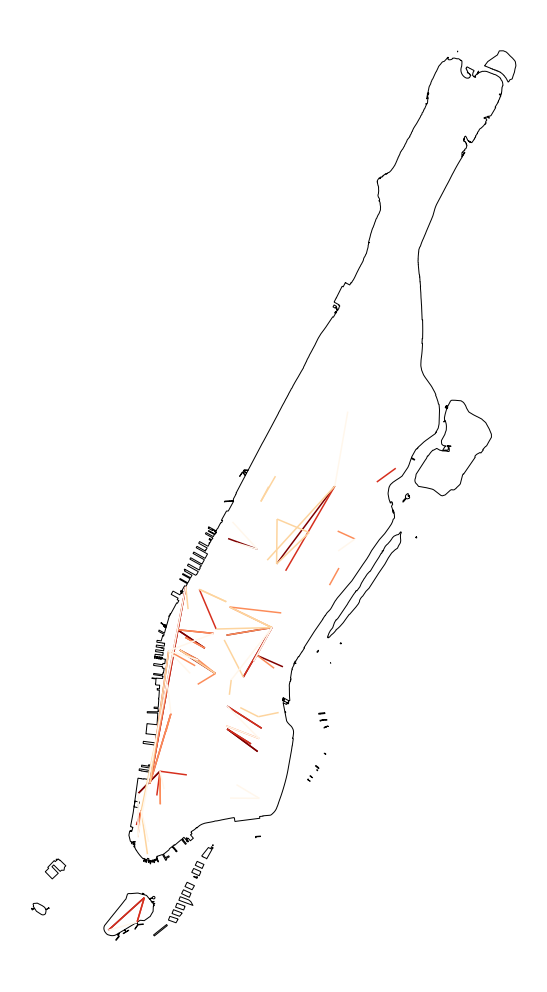

In [207]:
ax = cbLinesMn.plot(markersize=.1, figsize=(18,18), column='count', cmap='OrRd', scheme = 'quantiles')
nyc.loc[nyc.boro_code==1].plot(ax=ax, color='none',edgecolor='black')
ax.axis('off')

(-74.05899080015885, -73.68291469547655, 40.528875085084806, 40.81397034318728)

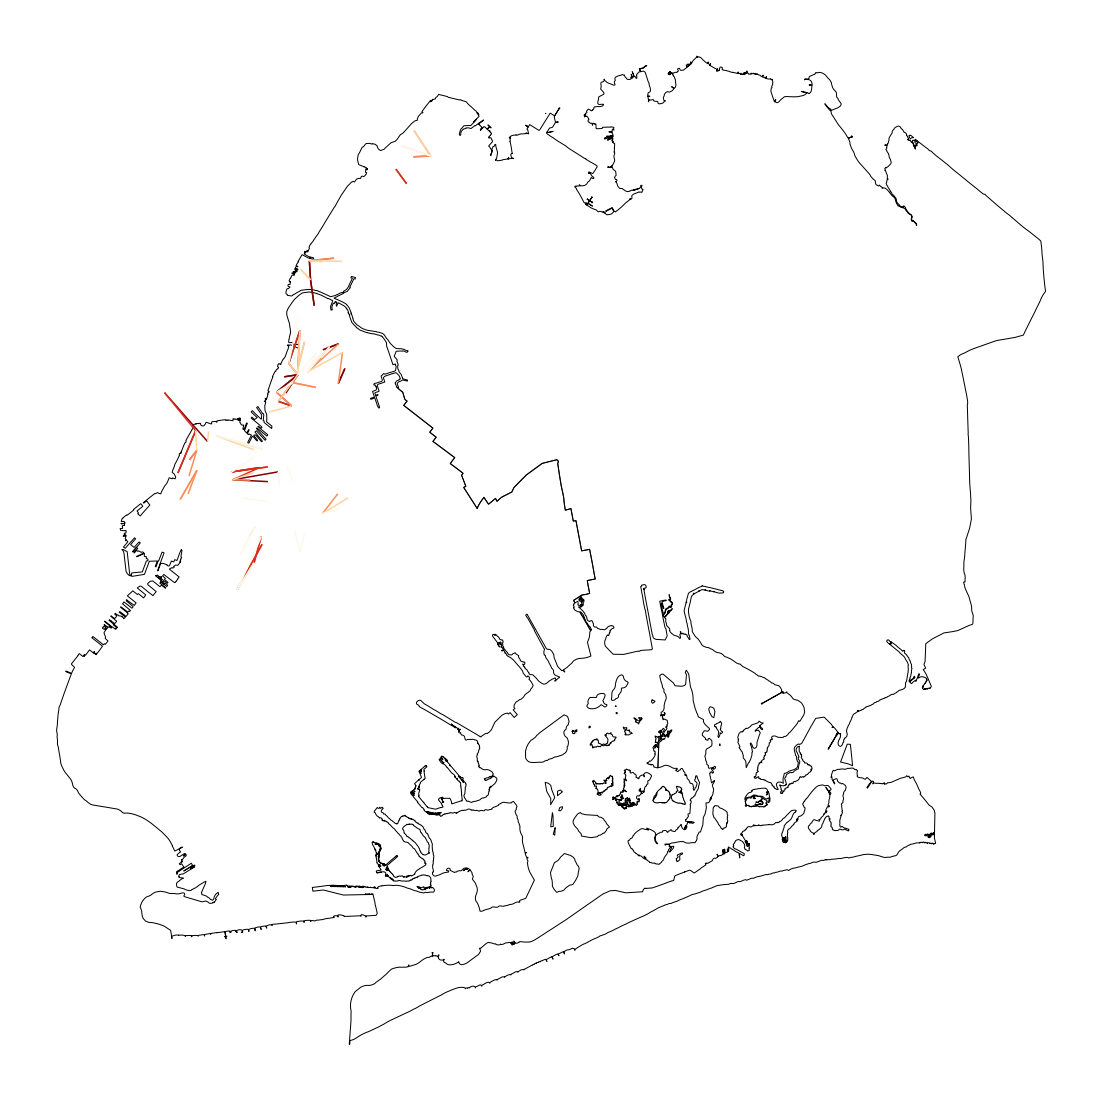

In [206]:
ax = cbLinesBQ.plot(markersize = .5, figsize=(20,20), column='count', cmap='OrRd', scheme = 'quantiles')
nyc.loc[(nyc.boro_code.isin([3,4])==True)].plot(ax=ax, color='none',edgecolor='black')
ax.axis('off')

In [208]:
cbLinesMn.to_file('cbLinesMn.shpe')
cbLinesBQ.to_file('cbLinesBQ.shpe')

In [157]:
cbRoutes.sort_values(['count'], ascending = False).head(30)

,,count,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude
start station id,end station id,,,,,,,
432.0,3263.0,8424,E 7 St & Avenue A,40.726218,-73.983799,Cooper Square & Astor Pl,40.729515,-73.990753
2006.0,3282.0,6086,Central Park S & 6 Ave,40.765909,-73.976342,5 Ave & E 88 St,40.783070,-73.959390
3664.0,327.0,5365,North Moore St & Greenwich St,40.720195,-74.010301,Vesey Pl & River Terrace,40.715338,-74.016584
327.0,3664.0,5270,Vesey Pl & River Terrace,40.715338,-74.016584,North Moore St & Greenwich St,40.720195,-74.010301
514.0,426.0,5055,12 Ave & W 40 St,40.760875,-74.002777,West St & Chambers St,40.717548,-74.013221
519.0,491.0,5050,Pershing Square North,40.751873,-73.977706,E 24 St & Park Ave S,40.740964,-73.986022
3118.0,3119.0,4996,McGuinness Blvd & Eagle St,40.735550,-73.952840,Vernon Blvd & 50 Ave,40.742327,-73.954117
3711.0,285.0,4915,E 13 St & Avenue A,40.729667,-73.980680,Broadway & E 14 St,40.734546,-73.990741
519.0,492.0,4897,Pershing Square North,40.751873,-73.977706,W 33 St & 7 Ave,40.750200,-73.990931


In [144]:
cbtestAgg.sort_values(['count'], ascending = False).head(30)

,,count,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude
start station id,end station id,,,,,,,
432.0,3263.0,554,E 7 St & Avenue A,40.726218,-73.983799,Cooper Square & Astor Pl,40.729515,-73.990753
3093.0,460.0,410,N 6 St & Bedford Ave,40.717452,-73.958509,S 4 St & Wythe Ave,40.712859,-73.965903
460.0,3093.0,372,S 4 St & Wythe Ave,40.712859,-73.965903,N 6 St & Bedford Ave,40.717452,-73.958509
459.0,3660.0,347,W 20 St & 11 Ave,40.746745,-74.007756,W 16 St & 8 Ave,40.741022,-74.001385
3664.0,327.0,344,North Moore St & Greenwich St,40.720195,-74.010301,Vesey Pl & River Terrace,40.715338,-74.016584
435.0,509.0,343,W 21 St & 6 Ave,40.741740,-73.994156,9 Ave & W 22 St,40.745497,-74.001971
519.0,492.0,337,Pershing Square North,40.751873,-73.977706,W 33 St & 7 Ave,40.750200,-73.990931
472.0,3687.0,325,E 32 St & Park Ave,40.745712,-73.981948,E 33 St & 1 Ave,40.743227,-73.974498
3660.0,459.0,319,W 16 St & 8 Ave,40.741022,-74.001385,W 20 St & 11 Ave,40.746745,-74.007756


## Citibike Demand

In [64]:
cbOrig = cb[['count','start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude']]\
.groupby(['start station id'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [65]:
cbOrig.sort_values(by = 'count', ascending=False)

,count,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude
start station id,,,,,,,
519.0,155511,Pershing Square North,40.751873,-73.977706,E 39 St & 2 Ave,40.747804,-73.973442
497.0,119932,E 17 St & Broadway,40.737050,-73.990093,E 16 St & Irving Pl,40.735367,-73.987974
3255.0,118982,8 Ave & W 31 St,40.750585,-73.994685,11 Ave & W 27 St,40.751396,-74.005226
402.0,111879,Broadway & E 22 St,40.740343,-73.989551,University Pl & E 8 St,40.731437,-73.994903
285.0,111669,Broadway & E 14 St,40.734546,-73.990741,Garfield Pl & 8 Ave,40.671198,-73.974841
...,...,...,...,...,...,...,...
3867.0,8,Somers St & Broadway,40.679450,-73.904740,Albany Ave & Fulton St,40.680011,-73.938475
3250.0,6,58th St Depot,40.716910,-73.983838,2 Ave & 36 St - Citi Bike HQ at Industry City,40.657089,-74.008702
3909.0,6,Madison St & Woodward Ave,40.704080,-73.904080,Lewis Ave & Madison St,40.686312,-73.935775


In [66]:
cbDest = cb[['count','start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude']]\
.groupby(['end station id'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})

In [67]:
geometryO = [Point(xy) for xy in zip(cbOrig['start station longitude'], cbOrig['start station latitude'])]
cbOrigGeo = GeoDataFrame(cbOrig, crs="EPSG:4326", geometry=geometryO)

In [68]:
geometryD = [Point(xy) for xy in zip(cbDest['end station longitude'], cbDest['end station latitude'])]
cbDestGeo = GeoDataFrame(cbDest, crs="EPSG:4326", geometry=geometryD)

In [69]:
cbTracts = gpd.sjoin(tracts, cbOrigGeo, op='intersects', how='inner')

In [247]:
cbTracts.columns

Index(['CTLABEL', 'BOROCODE', 'BORONAME', 'CT2000', 'BOROCT2000', 'CDELIGIBIL',
       'PJAREACODE', 'PJAREANAME', 'PUMA', 'SHAPE_LENG', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry', 'TractID', 'index_right', 'count',
       'start station name', 'start station latitude',
       'start station longitude', 'end station name', 'end station latitude',
       'end station longitude'],
      dtype='object')

In [70]:


cbTracts = cbTracts.groupby(['TractID'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'}).copy()


In [249]:
cbTracts

,count,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude
TractID,,,,,,,
100,7,47 Ave & Skillman Ave,40.743752,-73.941765,5 St & 51 Ave,40.742374,-73.956600
202,3,Cherry St,40.712199,-73.979481,E 32 St & Park Ave,40.745712,-73.981948
301,1,Hicks St & Montague St,40.695128,-73.995951,Schermerhorn St & Bond St,40.688417,-73.984517
302,4,Brooklyn Bridge Park - Pier 2,40.698458,-73.997178,Columbia St & Degraw St,40.685930,-74.002424
500,5,Picnic Point,40.685126,-74.025353,Soissons Landing,40.692317,-74.014866
...,...,...,...,...,...,...,...
57500,1,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,Meserole Ave & Manhattan Ave,40.727086,-73.952991
57700,2,India St & West St,40.731814,-73.959950,44 Dr & Jackson Ave,40.747182,-73.943264
57900,4,Calyer St & Jewel St,40.729840,-73.948390,Graham Ave & Conselyea St,40.715143,-73.944507


In [71]:
cbDemand = cbOrigGeo[['count','geometry']].copy()

In [72]:
tracts

,CTLABEL,BOROCODE,BORONAME,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry,TractID
0,43,4,Queens,004300,4004300,E,QN68,Qnsbridge-Ravenswd-LngIslCityN,4101,6401.411786,1.838665e+06,6401.411871,"POLYGON ((-73.93541 40.76350, -73.93398 40.762...",4300
1,44.01,4,Queens,004401,4004401,E,QN56,Ozone Park,4113,7561.021748,2.776681e+06,7561.021754,"POLYGON ((-73.85748 40.67817, -73.85687 40.676...",4401
2,44.02,4,Queens,004402,4004402,I,QN57,Lindenwood - Howard Beach,4113,5139.834810,1.065308e+06,5139.834769,"POLYGON ((-73.85655 40.67263, -73.85633 40.672...",4402
3,45,4,Queens,004500,4004500,I,QN70,Astoria,4101,7936.395515,2.371836e+06,7936.395385,"POLYGON ((-73.93225 40.76553, -73.93169 40.765...",4500
4,47,4,Queens,004700,4004700,E,QN70,Astoria,4101,5564.465823,1.929218e+06,5564.465936,"POLYGON ((-73.93158 40.76171, -73.93055 40.761...",4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,517,4,Queens,051700,4051700,E,QN30,Maspeth,4110,10148.515885,2.965986e+06,10148.515814,"POLYGON ((-73.89534 40.72592, -73.89504 40.725...",51700
2212,592,4,Queens,059200,4059200,I,QN33,Cambria Heights,4105,11076.724898,2.725896e+06,11076.724811,"POLYGON ((-73.72728 40.70579, -73.72689 40.705...",59200
2213,623,4,Queens,062300,4062300,I,QN19,Glendale,4110,5386.739581,1.688941e+06,5386.739504,"POLYGON ((-73.87652 40.70506, -73.87630 40.704...",62300
2214,654,4,Queens,065400,4065400,I,QN05,Rosedale,4105,16379.760609,7.524074e+06,16379.760452,"POLYGON ((-73.72981 40.66643, -73.72985 40.665...",65400


In [73]:
cbDemand = gpd.sjoin(tracts, cbDemand, op='intersects', how='inner')

In [74]:
cbDemand = cbDemand[['TractID','count','geometry']].groupby(['TractID']).agg({'count':'sum', 'geometry':'first'})

In [257]:
cbDemand

,count,geometry
TractID,,
100,57532,"POLYGON ((-73.93726 40.74518, -73.93765 40.743..."
202,74341,"POLYGON ((-73.97519 40.71450, -73.97521 40.714..."
301,22856,"POLYGON ((-73.99515 40.69877, -73.99429 40.698..."
302,50676,"POLYGON ((-73.99233 40.70186, -73.99275 40.701..."
500,61667,"POLYGON ((-74.01183 40.69216, -74.01184 40.692..."
...,...,...
57500,21386,"POLYGON ((-73.95148 40.73046, -73.95066 40.729..."
57700,26365,"POLYGON ((-73.95972 40.73713, -73.95971 40.737..."
57900,21760,"POLYGON ((-73.94073 40.73329, -73.94064 40.733..."


In [263]:
cbDemand['cbIndex'] = (cbDemand['count'])/(max(cbDemand['count']))

In [264]:
cbDemand

,count,geometry,cbIndex
TractID,,,
100,57532,"POLYGON ((-73.93726 40.74518, -73.93765 40.743...",0.102558
202,74341,"POLYGON ((-73.97519 40.71450, -73.97521 40.714...",0.132523
301,22856,"POLYGON ((-73.99515 40.69877, -73.99429 40.698...",0.040744
302,50676,"POLYGON ((-73.99233 40.70186, -73.99275 40.701...",0.090337
500,61667,"POLYGON ((-74.01183 40.69216, -74.01184 40.692...",0.109930
...,...,...,...
57500,21386,"POLYGON ((-73.95148 40.73046, -73.95066 40.729...",0.038123
57700,26365,"POLYGON ((-73.95972 40.73713, -73.95971 40.737...",0.046999
57900,21760,"POLYGON ((-73.94073 40.73329, -73.94064 40.733...",0.038790


In [268]:
path = '/Users/nicoleallegretti/Desktop/NYU/Courses/03_Summer21/Capstone/Data/CitiBike/History'
unzipFiles(path)

In [75]:
folder = 'CitiBike/History/'
files = [folder+'201603-citibike-tripdata.csv',
        folder+'201607-citibike-tripdata.csv',
        folder+'201611-citibike-tripdata.csv',
        folder+'201703-citibike-tripdata.csv',
        folder+'201707-citibike-tripdata.csv',
        folder+'201711-citibike-tripdata.csv',
        folder+'201803-citibike-tripdata.csv',
        folder+'201807-citibike-tripdata.csv',
        folder+'201811-citibike-tripdata.csv',
        folder+'201903-citibike-tripdata.csv',
        folder+'201907-citibike-tripdata.csv',
        folder+'201911-citibike-tripdata.csv']

In [76]:
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

In [77]:
#fix differences in column names (2 and 3 have mixed case instead of LC)
dfs[2].columns = dfs[1].columns
dfs[3].columns = dfs[1].columns

In [78]:
len(dfs[0]['start station id'].unique())

473

In [79]:
len(dfs[11]['start station id'].unique())

869

In [80]:
cbHist = pd.concat(dfs)

In [81]:
OriginalStations = dfs[0]['start station id'].unique()

In [82]:
#Filter
cbHist = cbHist.loc[(cbHist['start station id'].isin(OriginalStations)==True)] #for time series, do not include new stations constructed
cbHist = cbHist.loc[(cbHist.tripduration > (30))&(cbHist.tripduration<(3600*8))].copy()
cbHist = cbHist.loc[(cbHist['start station id']!=cbHist['end station id'])].copy()

In [301]:
cbHist.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72.0,W 52 St & 11 Ave,40.767272,-73.993929,427.0,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72.0,W 52 St & 11 Ave,40.767272,-73.993929,254.0,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72.0,W 52 St & 11 Ave,40.767272,-73.993929,493.0,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72.0,W 52 St & 11 Ave,40.767272,-73.993929,478.0,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72.0,W 52 St & 11 Ave,40.767272,-73.993929,151.0,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1


In [ ]:
#sample 3 months per year, march, July, November


In [83]:
cbHist['Timestamp'] = pd.to_datetime(cbHist.starttime, errors='coerce')
cbHist['Date']=cbHist.Timestamp.dt.date
cbHist['count'] = np.zeros(len(cbHist))

In [309]:
cbHist.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Timestamp,Date,count
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72.0,W 52 St & 11 Ave,40.767272,-73.993929,427.0,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1,2016-03-01 06:52:42,2016-03-01,0.0
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72.0,W 52 St & 11 Ave,40.767272,-73.993929,254.0,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1,2016-03-01 07:05:50,2016-03-01,0.0
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72.0,W 52 St & 11 Ave,40.767272,-73.993929,493.0,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2,2016-03-01 07:15:05,2016-03-01,0.0
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72.0,W 52 St & 11 Ave,40.767272,-73.993929,478.0,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1,2016-03-01 07:26:04,2016-03-01,0.0
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72.0,W 52 St & 11 Ave,40.767272,-73.993929,151.0,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1,2016-03-01 07:31:30,2016-03-01,0.0


In [84]:
geometry = [Point(xy) for xy in zip(cbHist['start station longitude'], cbHist['start station latitude'])]
cbHistGeo = GeoDataFrame(cbHist, crs="EPSG:4326", geometry=geometry)

In [85]:
cbHistTract = cbHistGeo[['count','geometry']].copy()
cbHistTract = gpd.sjoin(tracts, cbHistTract, op='intersects', how='inner')
cbHistTract = cbHistTract[['TractID','count','geometry']].groupby(['TractID']).agg({'count':'sum', 'geometry':'first'})

In [321]:
cbHistTract.head()

,count,geometry
TractID,,
100,0.0,"POLYGON ((-73.93726 40.74518, -73.93765 40.743..."
200,0.0,"POLYGON ((-74.00879 40.65696, -74.00659 40.655..."
202,0.0,"POLYGON ((-73.97519 40.71450, -73.97521 40.714..."
301,0.0,"POLYGON ((-73.99515 40.69877, -73.99429 40.698..."
302,0.0,"POLYGON ((-73.99233 40.70186, -73.99275 40.701..."


In [ ]:
# do this but map for the 4 years?
#aggregate by tract, year, 4 plots

In [307]:
cbHistAgg = cbHist.groupby('Date').agg({'count':'count'})

In [308]:
cbHistAgg

,count
Date,
2016-03-01,30073
2016-03-02,25910
2016-03-03,23801
2016-03-04,17145
2016-03-05,17633
...,...
2019-11-26,62638
2019-11-27,50392
2019-11-28,15534


In [86]:
cbOrig = cb[['count','start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude']]\
.groupby(['start station id'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [87]:
geometryO = [Point(xy) for xy in zip(cbOrig['start station longitude'], cbOrig['start station latitude'])]
cbOrigGeo = GeoDataFrame(cbOrig, crs="EPSG:4326", geometry=geometryO)

In [88]:
cbTracts = gpd.sjoin(tracts, cbOrigGeo, op='intersects', how='inner')

In [89]:
cbTracts = cbTracts.groupby(['TractID'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [102]:
cbDemand = cbOrigGeo[['count','geometry']].copy()
cbDemand = gpd.sjoin(tracts, cbDemand, op='intersects', how='inner')
cbDemand = cbDemand[['TractID','count','geometry']].groupby(['TractID']).agg({'count':'sum', 'geometry':'first'}).copy()

In [104]:
cbDemand = gpd.GeoDataFrame(cbDemand, crs = 'epsg:4236', geometry = cbDemand['geometry'])

(-74.03330071506174, -73.88757788489247, 40.65001941400171, 40.880312772941764)

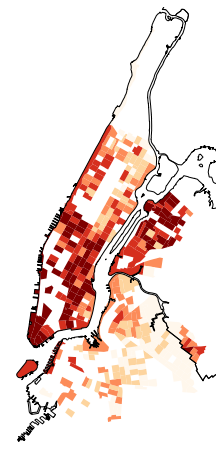

In [105]:
ax = cbDemand.plot(markersize=.1, figsize=(12, 8), column='count', cmap='OrRd', scheme = 'quantiles')
#ax = cbDemand.plot(markersize=.1, figsize=(12, 8), cmap='OrRd')
plt.autoscale(False)
nyc.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

In [24]:
cbOriginsSum = cbOrig.groupby(['start station id','start station name']).count()

In [26]:
cbOriginsSum.head()

,,tripduration,starttime,stoptime,start station latitude,start station longitude,usertype,geometry
start station id,start station name,,,,,,,
72,W 52 St & 11 Ave,3093,3093,3093,3093,3093,3093,3093
79,Franklin St & W Broadway,1687,1687,1687,1687,1687,1687,1687
82,St James Pl & Pearl St,958,958,958,958,958,958,958
83,Atlantic Ave & Fort Greene Pl,1445,1445,1445,1445,1445,1445,1445
116,W 17 St & 8 Ave,5572,5572,5572,5572,5572,5572,5572


In [ ]:
cbDestinationsSum = 

## Taxi

In [2]:
TaxiRepository = '/Users/nicoleallegretti/Desktop/NYU/Courses/03_Summer21/Capstone/Data/Taxi'
def downloadTaxi(year, month, TaxiRepository):
    url = f'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{year}-{month}.csv'
    save_to = TaxiRepository + f'/taxi_{year}-{month}.csv'
    urllib.request.urlretrieve(url, save_to)
    filename = f'taxi_{year}-{month}.csv'
    return filename

In [4]:
months = ['03', '07', '11']
years = ['2019']
files = []
for year in years:
    for month in months:
        files.append(downloadTaxi(year,month,TaxiRepository))
        

In [19]:
dtypes = {
'VendorID':                 int,
'tpep_pickup_datetime':     object,
'tpep_dropoff_datetime':    object,
'passenger_count':          int,
'trip_distance':            float,
'RatecodeID':               int,
'store_and_fwd_flag':       object,
'PULocationID':             int,
'DOLocationIDL':            int,
'payment_type':             int,
'fare_amount':              float,
'extra':                    float,
'mta_tax':                  float,
'tip_amount':               float,
'tolls_amount':             float,
'improvement_surcharge':    float,
'total_amount':             float,
'congestion_surcharge':     float
}

In [20]:
#dtypes = {'trip_distance': float, 'total_amount': float, 'RatecodeID': float, 'VendorID': float, 'passenger_count': float, 'payment_type':int, 'PULocationID':int, 'DOLocationID':int,'tolls_amount':float, 'fare_amount':float}

taxi = dd.read_csv('Taxi/*.csv', dtype = dtypes, blocksize=25e6)

In [12]:
t1 = dd.read_csv('Taxi/taxi_2019-03.csv')
t2 = dd.read_csv('Taxi/taxi_2019-07.csv')
t3 = dd.read_csv('Taxi/taxi_2019-11.csv')

In [14]:
t1.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [15]:
t2.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [16]:
t3.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [30]:
t1 =  pd.read_csv('Taxi/taxi_2019-03.csv')
#t2 = pd.read_csv('Taxi/taxi_2019-07.csv')
t3 = pd.read_csv('Taxi/taxi_2019-11.csv')

In [32]:
taxi = pd.concat([t1, t3])

In [33]:
taxi = taxi.drop_duplicates()
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['Date'] = taxi['tpep_pickup_datetime'].dt.date

In [34]:
ProgressBar().register()

In [35]:
%time taxidemand = taxi[['PULocationID','passenger_count']].groupby(['PULocationID'])\
.agg({'passenger_count':'sum' })

CPU times: user 1.24 s, sys: 879 ms, total: 2.12 s
Wall time: 2.3 s


In [36]:
%time taxiroutes= taxi[['PULocationID','DOLocationID','passenger_count']].groupby(['PULocationID','DOLocationID'])\
.agg({'passenger_count':'sum' })

CPU times: user 968 ms, sys: 545 ms, total: 1.51 s
Wall time: 1.65 s


In [37]:
taxidemand.head()

,passenger_count
PULocationID,
1,2093.0
2,5.0
3,399.0
4,42274.0
5,52.0


In [339]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [23]:
taxi = taxi.drop_duplicates()
taxi = taxi.dropna()

## Tracts Distance

In [92]:
# model function

def gravity(T_i, T_j, C_ij, mob_gt):
    
    X = sm.add_constant(np.log(C_ij))
    y = np.log(mob_gt) - np.log(T_i) - np.log(T_j)
    
    model = sm.OLS(y, X).fit()
    
    return model

In [ ]:
T_i = merged.numfloors * merged.yearbuilt 
T_j = merged.valueperarea * merged.PopDensity
model = gravity(T_i, T_j, ['DISTANCE'], allData.total)
model.summary()

In [5]:
tracts = gpd.read_file('2010CensusTracts/geo_export_604d3327-1f06-45be-8582-a46496d212b1.shp')

<AxesSubplot:>

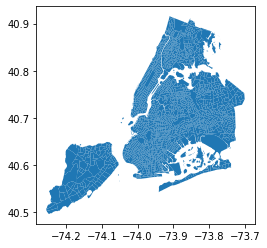

In [6]:
tracts.plot()

In [96]:
tracts['centroid'] = tracts.geometry.centroid

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [101]:
tracts.head()

,CTLABEL,BOROCODE,BORONAME,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry,TractID,centroid
0,43,4,Queens,004300,4004300,E,QN68,Qnsbridge-Ravenswd-LngIslCityN,4101,6401.411786,1.838665e+06,6401.411871,"POLYGON ((-73.93541 40.76350, -73.93398 40.762...",4300,POINT (-73.93751 40.76095)
1,44.01,4,Queens,004401,4004401,E,QN56,Ozone Park,4113,7561.021748,2.776681e+06,7561.021754,"POLYGON ((-73.85748 40.67817, -73.85687 40.676...",4401,POINT (-73.85940 40.67715)
2,44.02,4,Queens,004402,4004402,I,QN57,Lindenwood - Howard Beach,4113,5139.834810,1.065308e+06,5139.834769,"POLYGON ((-73.85655 40.67263, -73.85633 40.672...",4402,POINT (-73.85824 40.67210)
3,45,4,Queens,004500,4004500,I,QN70,Astoria,4101,7936.395515,2.371836e+06,7936.395385,"POLYGON ((-73.93225 40.76553, -73.93169 40.765...",4500,POINT (-73.93377 40.76453)
4,47,4,Queens,004700,4004700,E,QN70,Astoria,4101,5564.465823,1.929218e+06,5564.465936,"POLYGON ((-73.93158 40.76171, -73.93055 40.761...",4700,POINT (-73.93316 40.76029)


In [104]:
points = tracts['centroid']

In [102]:
from shapely.geometry import Polygon, LineString, Point

In [22]:
d1 = points.distance(points[0])
d2 = points.distance(points[1])


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [21]:
d1

0       0.000000
1       0.161694
2       0.159664
3       0.158504
4       0.147291
          ...   
2160    0.189164
2161    0.095366
2162    0.098903
2163    0.079530
2164    0.186397
Length: 2165, dtype: float64

In [23]:
d2

0       0.161694
1       0.000000
2       0.007601
3       0.011085
4       0.020121
          ...   
2160    0.028607
2161    0.077431
2162    0.078338
2163    0.091571
2164    0.025853
Length: 2165, dtype: float64

In [40]:
test1 = d1[0:2]
test2 = d2[0:2]

In [39]:
test1

0    0.000000
1    0.161694
dtype: float64

In [41]:
test2

0    0.161694
1    0.000000
dtype: float64

In [49]:
t12 = np.append([[test1]], [[test2]], axis = 1)
t12

array([[[0.       , 0.1616944],
        [0.1616944, 0.       ]]])

In [52]:
t12= np.asmatrix(t12)
t12

matrix([[0.       , 0.1616944],
        [0.1616944, 0.       ]])

In [107]:
dist = []
for i in range(0, len(points)):
    #calculate distance between each point
    d = points.distance(points[i])
    # d = (jobs + economic potential)/cost*distance^2
    dist.append(d)
#arrays = np.array(arrays)
matrix = np.asmatrix(dist)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [86]:
print(matrix)

[[0.         0.1616944  0.15966377 ... 0.09890269 0.07953045 0.18639658]
 [0.1616944  0.         0.00760063 ... 0.07833822 0.09157122 0.02585292]
 [0.15966377 0.00760063 0.         ... 0.08008053 0.09201036 0.02673432]
 ...
 [0.09890269 0.07833822 0.08008053 ... 0.         0.01941277 0.10395709]
 [0.07953045 0.09157122 0.09201036 ... 0.01941277 0.         0.11742253]
 [0.18639658 0.02585292 0.02673432 ... 0.10395709 0.11742253 0.        ]]


In [74]:
for i in range(0, len(dist)):
    arrays = [np.append([[dist[i]]]) for i in range(0,3)]
    
t12 = np.append([[test1]], [[test2]], axis = 1)
t12

0       0.000000
1       0.161694
2       0.159664
3       0.158504
4       0.147291
          ...   
2160    0.189164
2161    0.095366
2162    0.098903
2163    0.079530
2164    0.186397
Length: 2165, dtype: float64

In [83]:
matrix = np.asmatrix(arrays)

In [108]:
matrix

matrix([[0.        , 0.11456406, 0.11906917, ..., 0.08196806, 0.22067159,
         0.10904853],
        [0.11456406, 0.        , 0.00517558, ..., 0.0330928 , 0.12024354,
         0.06555176],
        [0.11906917, 0.00517558, 0.        , ..., 0.03794909, 0.11858148,
         0.06968859],
        ...,
        [0.08196806, 0.0330928 , 0.03794909, ..., 0.        , 0.14436273,
         0.05677182],
        [0.22067159, 0.12024354, 0.11858148, ..., 0.14436273, 0.        ,
         0.11741744],
        [0.10904853, 0.06555176, 0.06968859, ..., 0.05677182, 0.11741744,
         0.        ]])

In [110]:
matrix_df = pd.DataFrame(matrix)

In [111]:
matrix_df

,0,1,2,3,4,5,6,7,8,9,...,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215
0,0.000000,0.114564,0.119069,0.005189,0.004406,0.003649,0.117219,0.007553,0.115299,0.008263,...,0.118203,0.064135,0.201554,0.167455,0.061325,0.051628,0.216344,0.081968,0.220672,0.109049
1,0.114564,0.000000,0.005176,0.114750,0.111147,0.111025,0.004467,0.107018,0.005954,0.108654,...,0.011273,0.098513,0.112929,0.084839,0.059453,0.063043,0.132197,0.033093,0.120244,0.065552
2,0.119069,0.005176,0.000000,0.119364,0.115713,0.115511,0.006508,0.111532,0.009370,0.113283,...,0.008337,0.103678,0.112630,0.085599,0.064535,0.067661,0.132097,0.037949,0.118581,0.069689
3,0.005189,0.114750,0.119364,0.000000,0.004288,0.007056,0.117242,0.009041,0.115217,0.006140,...,0.118859,0.059777,0.199281,0.165168,0.059978,0.051710,0.213771,0.081895,0.218974,0.106295
4,0.004406,0.111147,0.115713,0.004288,0.000000,0.003613,0.113715,0.004759,0.111741,0.003885,...,0.115058,0.060034,0.197232,0.163128,0.057213,0.048119,0.211975,0.078402,0.216484,0.104657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,0.051628,0.063043,0.067661,0.051710,0.048119,0.048142,0.065605,0.044075,0.063672,0.045623,...,0.067458,0.055830,0.156140,0.122611,0.017957,0.000000,0.172660,0.030349,0.172227,0.070220
2212,0.216344,0.132197,0.132097,0.213771,0.211975,0.213777,0.127737,0.209750,0.126907,0.208262,...,0.139918,0.162585,0.019937,0.050156,0.157170,0.172660,0.000000,0.148737,0.040556,0.107576
2213,0.081968,0.033093,0.037949,0.081895,0.078402,0.078491,0.035358,0.074416,0.033339,0.075774,...,0.039148,0.070139,0.131018,0.098723,0.027551,0.030349,0.148737,0.000000,0.144363,0.056772
2214,0.220672,0.120244,0.118581,0.218974,0.216484,0.217669,0.115923,0.213505,0.116065,0.213054,...,0.125217,0.175239,0.031836,0.058459,0.159416,0.172227,0.040556,0.144363,0.000000,0.117417


In [112]:
# Function which returns subset or r length from n
from itertools import combinations
  
def rSubset(arr, r):
  
    # return list of all subsets of length r
    # to deal with duplicate subsets use 
    # set(list(combinations(arr, r)))
    return list(combinations(arr, r))
  


In [113]:
tracts

,CTLABEL,BOROCODE,BORONAME,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry,TractID,centroid
0,43,4,Queens,004300,4004300,E,QN68,Qnsbridge-Ravenswd-LngIslCityN,4101,6401.411786,1.838665e+06,6401.411871,"POLYGON ((-73.93541 40.76350, -73.93398 40.762...",4300,POINT (-73.93751 40.76095)
1,44.01,4,Queens,004401,4004401,E,QN56,Ozone Park,4113,7561.021748,2.776681e+06,7561.021754,"POLYGON ((-73.85748 40.67817, -73.85687 40.676...",4401,POINT (-73.85940 40.67715)
2,44.02,4,Queens,004402,4004402,I,QN57,Lindenwood - Howard Beach,4113,5139.834810,1.065308e+06,5139.834769,"POLYGON ((-73.85655 40.67263, -73.85633 40.672...",4402,POINT (-73.85824 40.67210)
3,45,4,Queens,004500,4004500,I,QN70,Astoria,4101,7936.395515,2.371836e+06,7936.395385,"POLYGON ((-73.93225 40.76553, -73.93169 40.765...",4500,POINT (-73.93377 40.76453)
4,47,4,Queens,004700,4004700,E,QN70,Astoria,4101,5564.465823,1.929218e+06,5564.465936,"POLYGON ((-73.93158 40.76171, -73.93055 40.761...",4700,POINT (-73.93316 40.76029)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,517,4,Queens,051700,4051700,E,QN30,Maspeth,4110,10148.515885,2.965986e+06,10148.515814,"POLYGON ((-73.89534 40.72592, -73.89504 40.725...",51700,POINT (-73.90055 40.72490)
2212,592,4,Queens,059200,4059200,I,QN33,Cambria Heights,4105,11076.724898,2.725896e+06,11076.724811,"POLYGON ((-73.72728 40.70579, -73.72689 40.705...",59200,POINT (-73.72948 40.70157)
2213,623,4,Queens,062300,4062300,I,QN19,Glendale,4110,5386.739581,1.688941e+06,5386.739504,"POLYGON ((-73.87652 40.70506, -73.87630 40.704...",62300,POINT (-73.87819 40.70439)
2214,654,4,Queens,065400,4065400,I,QN05,Rosedale,4105,16379.760609,7.524074e+06,16379.760452,"POLYGON ((-73.72981 40.66643, -73.72985 40.665...",65400,POINT (-73.74006 40.66242)


In [115]:
tracts['TractBoro'] = tracts.TractID.astype(str) + tracts.BOROCODE.astype(str)


In [120]:
arr = np.array(tracts['TractBoro'])

In [124]:
len(arr)

2216

In [133]:
arr1 = arr[0:4]

In [140]:
arr1 = arr[0:500]

In [128]:
# Driver Function
if __name__ == "__main__":
    arr = arr
    r = 2
    print (rSubset(arr, r))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [141]:
r = 2
combo = rSubset(arr1, r)
print(combo)

[('43004', '44014'), ('43004', '44024'), ('43004', '45004'), ('43004', '47004'), ('43004', '49004'), ('43004', '50004'), ('43004', '51004'), ('43004', '52004'), ('43004', '53004'), ('43004', '54004'), ('43004', '55004'), ('43004', '57004'), ('43004', '58004'), ('43004', '59004'), ('43004', '61004'), ('43004', '62004'), ('43004', '63004'), ('43004', '65004'), ('43004', '67004'), ('43004', '69004'), ('43004', '71004'), ('43004', '73004'), ('43004', '75004'), ('43004', '77004'), ('43004', '79004'), ('43004', '83004'), ('43004', '86004'), ('43004', '88004'), ('43004', '91004'), ('43004', '94004'), ('43004', '95004'), ('43004', '96004'), ('43004', '97004'), ('43004', '98004'), ('43004', '99004'), ('43004', '100004'), ('43004', '101004'), ('43004', '102004'), ('43004', '103004'), ('43004', '104004'), ('43004', '105004'), ('43004', '106004'), ('43004', '107004'), ('43004', '108004'), ('43004', '110004'), ('43004', '111004'), ('43004', '112004'), ('43004', '113004'), ('43004', '114004'), ('430

In [142]:
dfcombo = pd.DataFrame(combo)

In [143]:
dfcombo

,0,1
0,43004,44014
1,43004,44024
2,43004,45004
3,43004,47004
4,43004,49004
...,...,...
124745,934004,942014
124746,934004,942024
124747,939004,942014
124748,939004,942024
